In [1]:
# Final Project Analysis
# Classification Modeling Problem
# DSC 630
# Matthew Fikes
# 8/6/2021

#### loading data and libraries

In [7]:
# imports
import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

from sklearn.model_selection import train_test_split
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.classifier import ROCAUC
import matplotlib.pyplot as plt

import sklearn.metrics
import os
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from autoviz.AutoViz_Class import AutoViz_Class
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

In [8]:
# load dual credit data
df = pd.read_excel('Dual_Data_Final.xls')

# remove extra fields for later clustering
df.drop(['Matric_Term','Program'], axis=1,inplace = True)




# make columns for courses
df['Courses'] = df['Courses'].str.split(',')
courselist=[]
for i in df['Courses']:
    for n in i:
        courselist.append(n.strip())
listing = list(set(courselist))
df = pd.concat([df,pd.DataFrame(columns=listing)])

# fill in course columns 
for index,row in df.iterrows():
    
    classes = row['Courses']
    for course in classes:
        cls = course.strip()
        
        df.at[index,cls] = 1






In [9]:
# fill empty cells after course encoding
df.fillna(0,axis=1,inplace=True)

In [10]:
# fix types
cat_cols = ['StartTerm','HS','Ethnicity','Sex']
for col in cat_cols:
    df[col] = df[col].astype('category')
     
data_cat_dummies=pd.get_dummies(df[cat_cols])


df_features = df.drop(cat_cols,axis=1)
df_features = df_features.drop(['ID','Courses','Matric'],axis=1)

In [12]:
#check for NA values
df.isna().any()

Num_Dual_Terms    False
StartYear         False
StartTerm         False
Courses           False
Matric            False
                  ...  
FR202             False
PT101             False
IS101             False
BM115             False
SO101             False
Length: 204, dtype: bool

In [13]:
# join features
data_model_x = pd.concat([df_features,data_cat_dummies],axis=1)

data_model_y=df['Matric'].astype('category')

# make test and training data
X_train, X_test, Y_train, Y_test= train_test_split(data_model_x,data_model_y,test_size=0.4,random_state=11)

data_model = data_model_x.assign(target=data_model_y)

In [ ]:
# check top 10 correlations
corr_chk = data_model.corrwith(data_model['target'])
corr_chk.sort_values(ascending=False,inplace=True)
corr_chk.head(10)

In [ ]:
# check bottom 10 correlations
corr_chk.tail(10)

In [ ]:
# uncomment to run EDA
#autoviz=AutoViz_Class().AutoViz('',',','Matric',df,max_cols_analyzed = 250)


In [ ]:
# uncomment to save model to csv
#data_model.to_csv('data_model.csv')

In [14]:
# print training and test information
print("Training samples: {}".format(X_train.shape[0]))
print("Validation samples: {}".format(X_test.shape[0]))
print(Y_train.value_counts())
print('Training Matriculation Rate: {0:.2f}%'.format((Y_train.value_counts()[1]/Y_train.value_counts()[0])*100))
print(Y_test.value_counts())
print('Test Matriculation Rate: {0:.2f}%'.format((Y_test.value_counts()[1]/Y_test.value_counts()[0])*100))

Training samples: 12085
Validation samples: 8058
0.0    7736
1.0    4349
Name: Matric, dtype: int64
Training Matriculation Rate: 56.22%
0.0    5106
1.0    2952
Name: Matric, dtype: int64
Test Matriculation Rate: 57.81%


### Decision Tree

In [35]:
DT_model = DecisionTreeClassifier(max_depth=20,criterion='entropy',min_samples_leaf=25).fit(X_train,Y_train)
DT_predict = DT_model.predict(X_test)
print(DT_predict)

[0. 0. 0. ... 0. 1. 0.]


0.6760982874162323

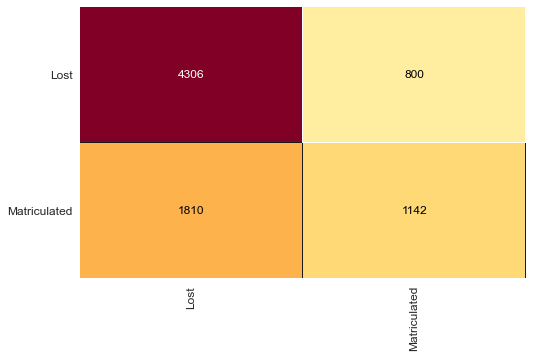

In [36]:
# decision tree confusion matrix
%matplotlib inline
classes = ['Lost','Matriculated']
cm = ConfusionMatrix(DT_model, classes=classes,percent=False)
cm.fit(X_train,Y_train)
plt.rcParams['figure.figsize']=(8,5)
plt.rcParams['font.size'] = 12
cm.score(X_test,Y_test)


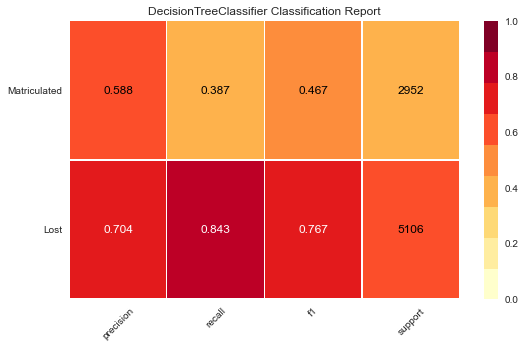

<AxesSubplot:title={'center':'DecisionTreeClassifier Classification Report'}>

In [37]:
# decision tree classification report
visualizer = ClassificationReport(DT_model, classes=classes,support=True)
visualizer.fit(X_train,Y_train)
visualizer.score(X_test,Y_test)
visualizer.show()

In [ ]:
# uncomment to get text representation of decision tree
#text_representation = tree.export_text(DT_model)
#print(text_representation)

In [39]:
# plot decision tree
fig = plt.figure(figsize=(200,100))
_ = tree.plot_tree(DT_model, 
                   feature_names=data_model_x.columns,  
                   class_names=classes,
                   filled=True)

In [20]:
# load and train Random Forest Classification model
rfc = RandomForestClassifier(oob_score=True,criterion= 'entropy', max_features= None, min_samples_leaf= 25, n_estimators= 200)
rfc.fit(X_train,Y_train)
y_pred=rfc.predict(X_test)
y_prob=rfc.predict_proba(X_test)

In [ ]:
# get avg absolute error for random forest
labels = Y_test.values.to_numpy()
error = abs(y_pred - labels)

print('Average absolute error:', round(np.mean(error), 2), 'degrees.')


In [21]:
# metrics
f1 = sklearn.metrics.f1_score(Y_test, y_pred, average = 'weighted',labels=np.unique(y_pred))
prec = sklearn.metrics.precision_score(Y_test, y_pred, average = 'weighted')
acc = sklearn.metrics.accuracy_score(Y_test, y_pred)
recall = sklearn.metrics.recall_score(Y_test, y_pred, average = 'weighted')

print('accuracy: {0}\nprecision: {1}\nrecall: {2}\nf1: {3}'.format(acc,prec,recall,f1))

accuracy: 0.686150409530901
precision: 0.6733678636662794
recall: 0.686150409530901
f1: 0.6670220647758335


In [ ]:
# plot feature importance for random forest
plt.figure(figsize=(8,20))
feature_imp = pd.Series(rfc.feature_importances_,index=data_model_x.columns).head(100).sort_values(ascending=False).head(10)
sns.barplot(x=feature_imp, y=feature_imp.index)

0.686150409530901

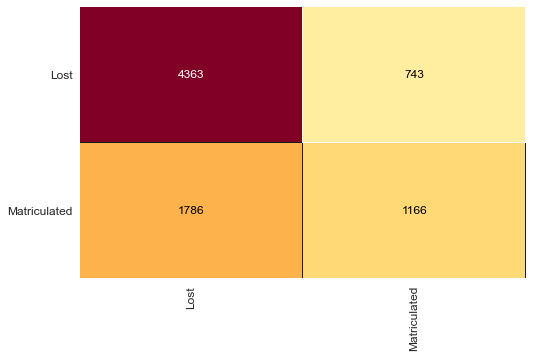

In [22]:
# random forest confusion matrix
classes = ['Lost','Matriculated']
cm = ConfusionMatrix(rfc, classes=classes,percent=False)
cm.fit(X_train,Y_train)
plt.rcParams['figure.figsize']=(8,5)
plt.rcParams['font.size'] = 12
cm.score(X_test,Y_test)

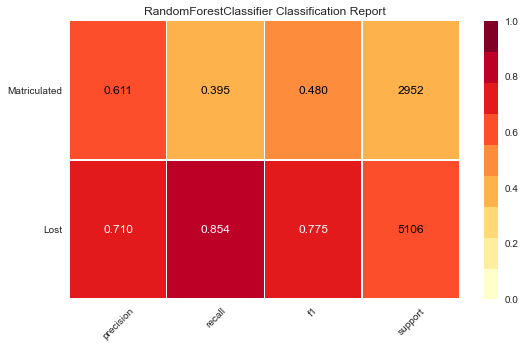

<AxesSubplot:title={'center':'RandomForestClassifier Classification Report'}>

In [23]:
# random forest classification report
visualizer = ClassificationReport(rfc, classes=classes,support=True)
visualizer.fit(X_train,Y_train)
visualizer.score(X_test,Y_test)
visualizer.show()

### Hyperparameter test for Decision Tree Classifier

In [25]:

# list params for multilayer perceptron model
DT_model.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 6,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

In [32]:
# load params to test for rfc model
DTparameter_space = {
    'criterion': ['gini','entropy'],
    'max_features': ['auto',None, 'sqrt',0.2],
    'min_samples_leaf': [None,1,10,25,50,100],
    'max_depth': [None,2,5,8,10,20],
    'min_samples_split':[1,2,4]
    
    
}

In [33]:
# test rfc params
clf = GridSearchCV(DT_model, DTparameter_space, n_jobs=-1, cv=5)
clf.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(max_depth=6), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 5, 8, 10, 20],
                         'max_features': ['auto', None, 'sqrt', 0.2],
                         'min_samples_leaf': [None, 1, 10, 25, 50, 100],
                         'min_samples_split': [1, 2, 4]})

In [34]:
# Best parameter set
print('Best parameters found:\n', clf.best_params_)

# All results
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

Best parameters found:
 {'criterion': 'entropy', 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 25, 'min_samples_split': 2}
nan (+/-nan) for {'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': None, 'min_samples_split': 1}
nan (+/-nan) for {'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': None, 'min_samples_split': 2}
nan (+/-nan) for {'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': None, 'min_samples_split': 4}
nan (+/-nan) for {'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 1}
0.642 (+/-0.011) for {'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2}
0.641 (+/-0.010) for {'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 4}
nan (+/-nan) for {'criterion': 'gini', 'max_depth': None, 'max_features':

### Hyperparameter test for Random Forest Classifier

In [ ]:

# list params for multilayer perceptron model
rfc.get_params()

In [ ]:
# load params to test for rfc model
rfcparameter_space = {
    'criterion': ['gini','entropy'],
    'max_features': ['auto',None, 'sqrt',0.2],
    'n_estimators': [50,100,200],
    'min_samples_leaf': [1,10,25,50],
    'max_depth': [None,2,5,8,10]
    
}

In [ ]:
# test rfc params
clf = GridSearchCV(rfc, rfcparameter_space, n_jobs=-1, cv=5)
clf.fit(X_train, Y_train)

In [ ]:
# Best parameter set
print('Best parameters found:\n', clf.best_params_)

# All results
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))